In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

import torch
import torch.nn as nn
import torch.optim as optim

from torchvision import transforms, datasets

import time

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize = 14)
mpl.rc('xtick', labelsize = 12)
mpl.rc('ytick', labelsize = 12)


PROJECT_ROOT_DIR = '.'
DATASET_NAME = 'flower_data'
DATASETS_PATH = os.path.join(PROJECT_ROOT_DIR, 'datasets')
DATASET_PATH = os.path.join(DATASETS_PATH, DATASET_NAME)
MODEL_PATH = os.path.join(PROJECT_ROOT_DIR, 'pretained')

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [3]:
from shutil import copy, rmtree

def mk_file(file_path: str):
    if os.path.exists(file_path):
        rmtree(file_path)
    os.makedirs(file_path)

In [4]:
original_dataset = os.path.join(DATASET_PATH, "flower_photos")

assert os.path.exists(original_dataset)
flower_class = [cla for cla in os.listdir(original_dataset)
                    if os.path.isdir(os.path.join(original_dataset, cla))]
num_class = len(flower_class)
print("数据集类别：" , flower_class)

数据集类别： ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


In [5]:
# 建立保存训练集的文件夹
train_root = os.path.join(DATASET_PATH, "train")
mk_file(train_root)
for cla in flower_class:
    # 建立每个类别对应的文件夹
    mk_file(os.path.join(train_root, cla))
        
# 建立保存验证集的文件夹
val_root = os.path.join(DATASET_PATH, "val")
mk_file(val_root)
for cla in flower_class:
    # 建立每个类别对应的文件夹
    mk_file(os.path.join(val_root, cla))

In [6]:
import random

split_rate = 0.1

for cla in flower_class:
    cla_path = os.path.join(original_dataset, cla)
    images = os.listdir(cla_path)
    num = len(images)
    # 随机采样验证集的索引
    eval_index = random.sample(images, k=int(num*split_rate))
    for index, image in enumerate(images):
        if image in eval_index:
            # 将分配至验证集中的文件复制到相应目录
            image_path = os.path.join(cla_path, image)
            new_path = os.path.join(val_root, cla)
            copy(image_path, new_path)
        else:
            # 将分配至训练集中的文件复制到相应目录
            image_path = os.path.join(cla_path, image)
            new_path = os.path.join(train_root, cla)
            copy(image_path, new_path)
        print("\r[{}] 训练验证样本分离 [{}/{}]".format(cla, index+1, num), end="") 
    print()


[daisy] 训练验证样本分离 [633/633]
[dandelion] 训练验证样本分离 [898/898]
[roses] 训练验证样本分离 [641/641]
[sunflowers] 训练验证样本分离 [699/699]
[tulips] 训练验证样本分离 [799/799]


In [7]:
data_transform = {
    "train": transforms.Compose([transforms.RandomResizedCrop(224),
                                 transforms.RandomHorizontalFlip(),
                                 transforms.ToTensor(),
                                 transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]),
    "val": transforms.Compose([transforms.Resize((224, 224)),  
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])}

In [8]:
batch_size = 32

train_dataset = datasets.ImageFolder(root=train_root,
                                     transform=data_transform["train"])

train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size=batch_size, shuffle=True,
                                           num_workers=0)

validate_dataset = datasets.ImageFolder(root=val_root,
                                   transform=data_transform["val"])

validate_loader = torch.utils.data.DataLoader(validate_dataset,
                                              batch_size=4, shuffle=True,
                                              num_workers=0)

train_num = len(train_dataset)
val_num = len(validate_dataset)
print("训练样本数：" , train_num)
print("验证样本数：" , val_num)

训练样本数： 3306
验证样本数： 364


In [9]:
class AlexNet(nn.Module):
    def __init__(self, num_classes=1000, init_weights=False):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )
        if init_weights:
            self._initialize_weights()

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, start_dim=1)
        x = self.classifier(x)
        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

In [10]:
net = AlexNet()

net.to(device)

model_weights_path = os.path.join(MODEL_PATH, 'alexnet-owt-4df8aa71.pth')
missing_keys, unexpected_keys = net.load_state_dict(torch.load(model_weights_path), strict=False)


In [11]:
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.0002)


save_path = './generated/AlexNet.pth'
best_acc = 0.0
loss_val = []
acc_scores = []
for epoch in range(30):
    
    net.train()
    running_loss = 0.0
    t1 = time.perf_counter()
    for step, data in enumerate(train_loader, start=0):
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = net(images)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        # print train process
        rate = (step + 1) / len(train_loader)
        a = "*" * int(rate * 50)
        b = "." * int((1 - rate) * 50)
        print("\rtrain loss: {:^3.0f}%[{}->{}]{:.3f}".format(int(rate * 100), a, b, loss), end="")
    print()
    print(time.perf_counter() - t1)

    # validate
    net.eval()
    acc = 0.0  # accumulate accurate number / epoch
    with torch.no_grad():
        for val_data in validate_loader:
            val_images, val_labels = val_data
            outputs = net(val_images.to(device))
            predict_y = torch.max(outputs, dim=1)[1]
            acc += (predict_y == val_labels.to(device)).sum().item()
        val_accurate = acc / val_num
        if val_accurate > best_acc:
            best_acc = val_accurate
            torch.save(net.state_dict(), save_path)
        print('[epoch %d] train_loss: %.3f  test_accuracy: %.3f' %
            (epoch + 1, running_loss / step, val_accurate))
        
        loss_val.append(running_loss / step)    
        acc_scores.append(val_accurate)

print('Finished Training')

C:\Users\sbzy\Anaconda3\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


train loss: 100%[**************************************************->]0.561
22.260418699999995
[epoch 1] train_loss: 1.076  test_accuracy: 0.791
train loss: 100%[**************************************************->]0.307
18.055617599999998
[epoch 2] train_loss: 0.598  test_accuracy: 0.824
train loss: 100%[**************************************************->]0.717
18.279919000000007
[epoch 3] train_loss: 0.509  test_accuracy: 0.827
train loss: 100%[**************************************************->]0.351
18.823308899999986
[epoch 4] train_loss: 0.446  test_accuracy: 0.838
train loss: 100%[**************************************************->]0.604
18.1901381
[epoch 5] train_loss: 0.407  test_accuracy: 0.849
train loss: 100%[**************************************************->]0.585
18.180712999999983
[epoch 6] train_loss: 0.409  test_accuracy: 0.876
train loss: 100%[**************************************************->]0.217
18.546216600000008
[epoch 7] train_loss: 0.359  test_accuracy:

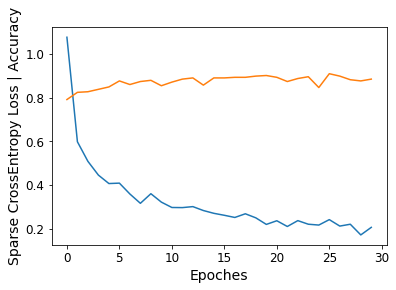

In [12]:
epoches = [x for x in range(30)]
plt.plot(epoches, loss_val, epoches, acc_scores)
plt.xlabel('Epoches')
plt.ylabel('Sparse CrossEntropy Loss | Accuracy')
plt.show()

In [13]:
def confusion_matrix(preds, labels, conf_matrix):
    for p, t in zip(preds, labels):
        conf_matrix[p, t] += 1
    return conf_matrix

In [22]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    

    plt.axis("equal")
    ax = plt.gca() 
    left, right = plt.xlim()  
    ax.spines['left'].set_position(('data', left))
    ax.spines['right'].set_position(('data', right))
    for edge_i in ['top', 'bottom', 'right', 'left']:
        ax.spines[edge_i].set_edgecolor("white")

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        num = '{:.2f}'.format(cm[i, j]) if normalize else int(cm[i, j])
        plt.text(j, i, num,
                 verticalalignment='center',
                 horizontalalignment="center",
                 color="white" if num > thresh else "black")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()


Confusion matrix, without normalization
[[52.  1.  1.  0.  0.]
 [ 7. 83.  1.  0.  1.]
 [ 1.  1. 49.  1.  7.]
 [ 0.  1.  1. 68.  1.]
 [ 3.  3. 12.  0. 70.]]


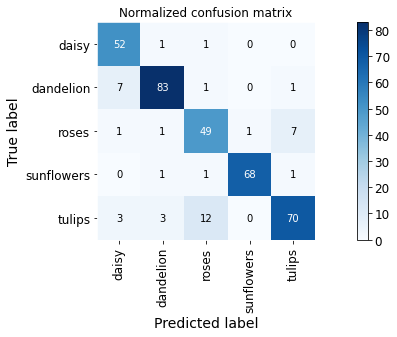

In [23]:
import itertools
import numpy as np

conf_matrix = torch.zeros(num_class, num_class)

with torch.no_grad():
    for val_data in validate_loader:
        val_images, val_labels = val_data
        outputs = net(val_images.to(device))
        predict_y = torch.max(outputs, dim=1)[1]
        conf_matrix = confusion_matrix(predict_y, labels=val_labels, conf_matrix=conf_matrix)

plot_confusion_matrix(conf_matrix.numpy(), classes=flower_class, normalize=False,
                                 title='Normalized confusion matrix')
